W0000 00:00:1756683324.105032     757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1756683324.128718     757 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1756683324.139938     755 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


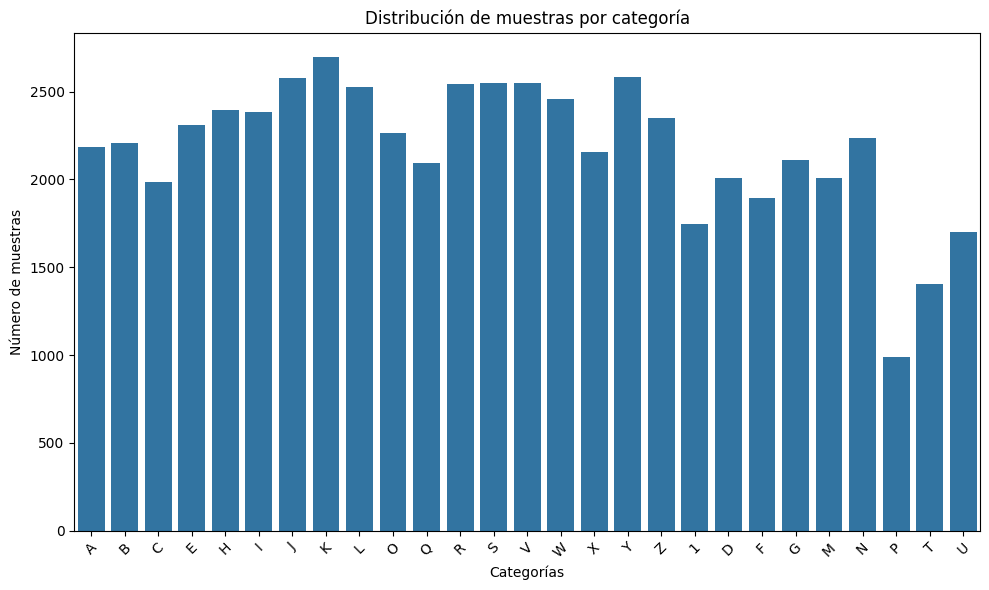

/tmp/ipykernel_690/1674359596.py:113: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 0].set_xticklabels(['X', 'Y', 'Z'])
/tmp/ipykernel_690/1674359596.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['X', 'Y', 'Z'])


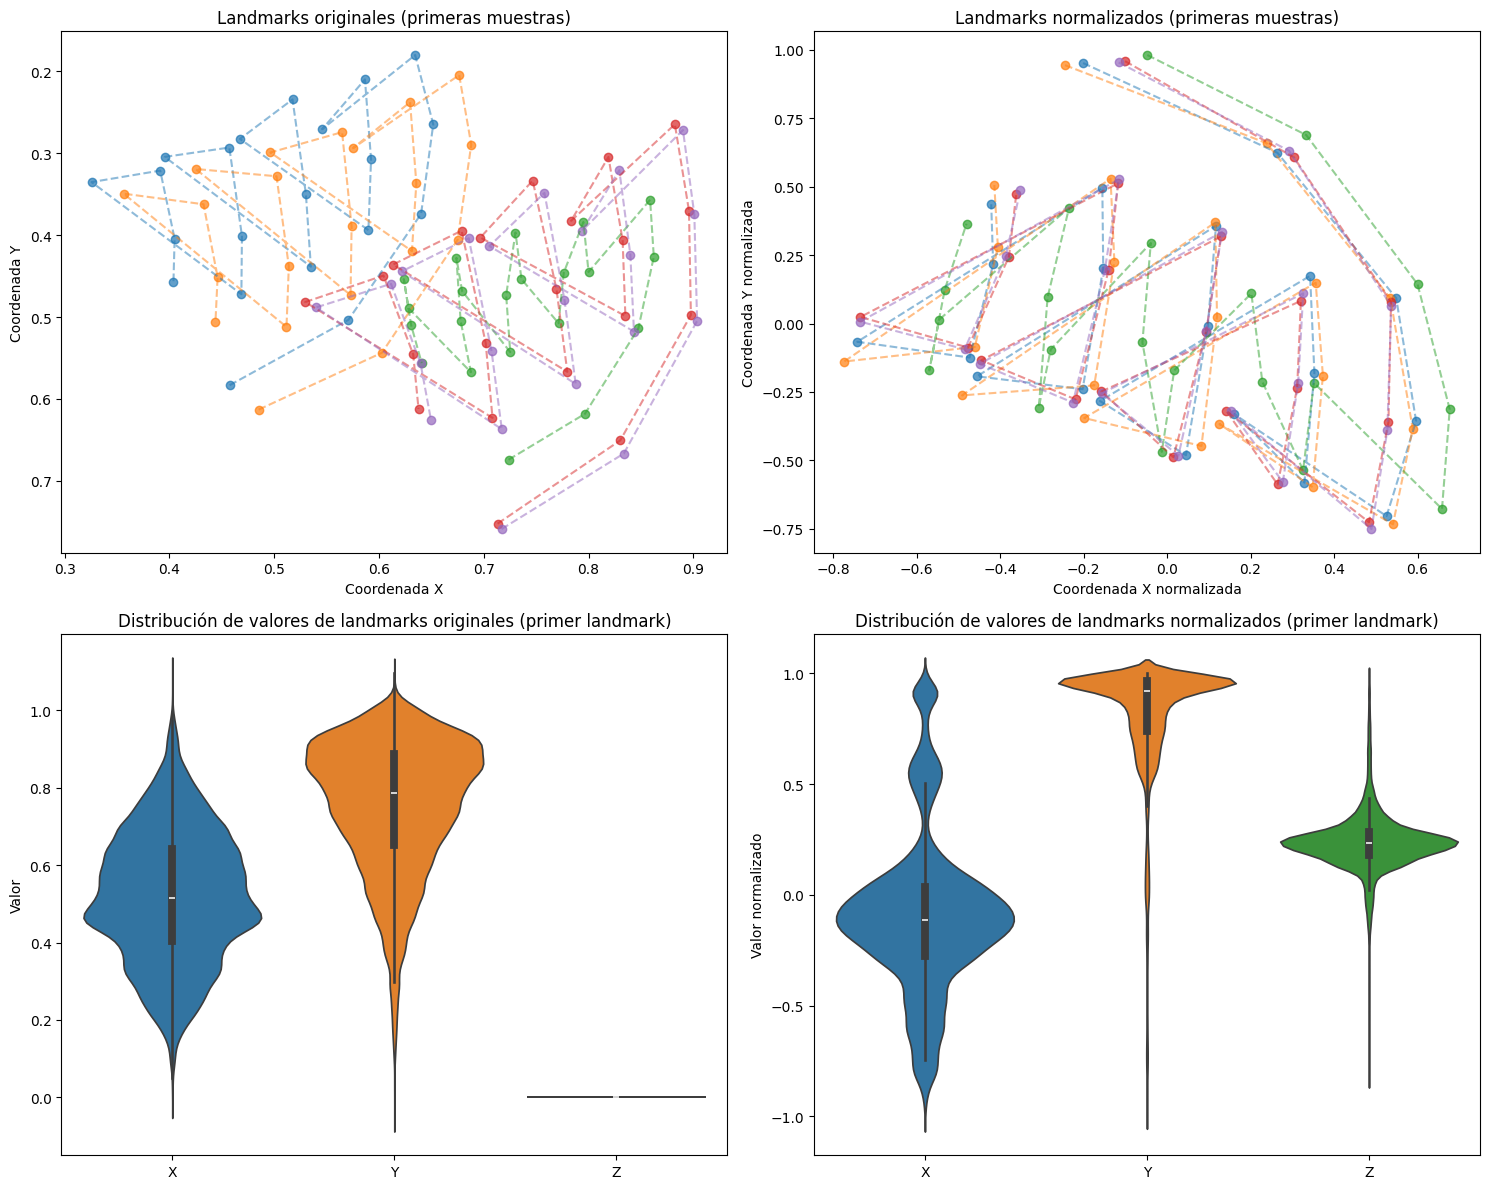

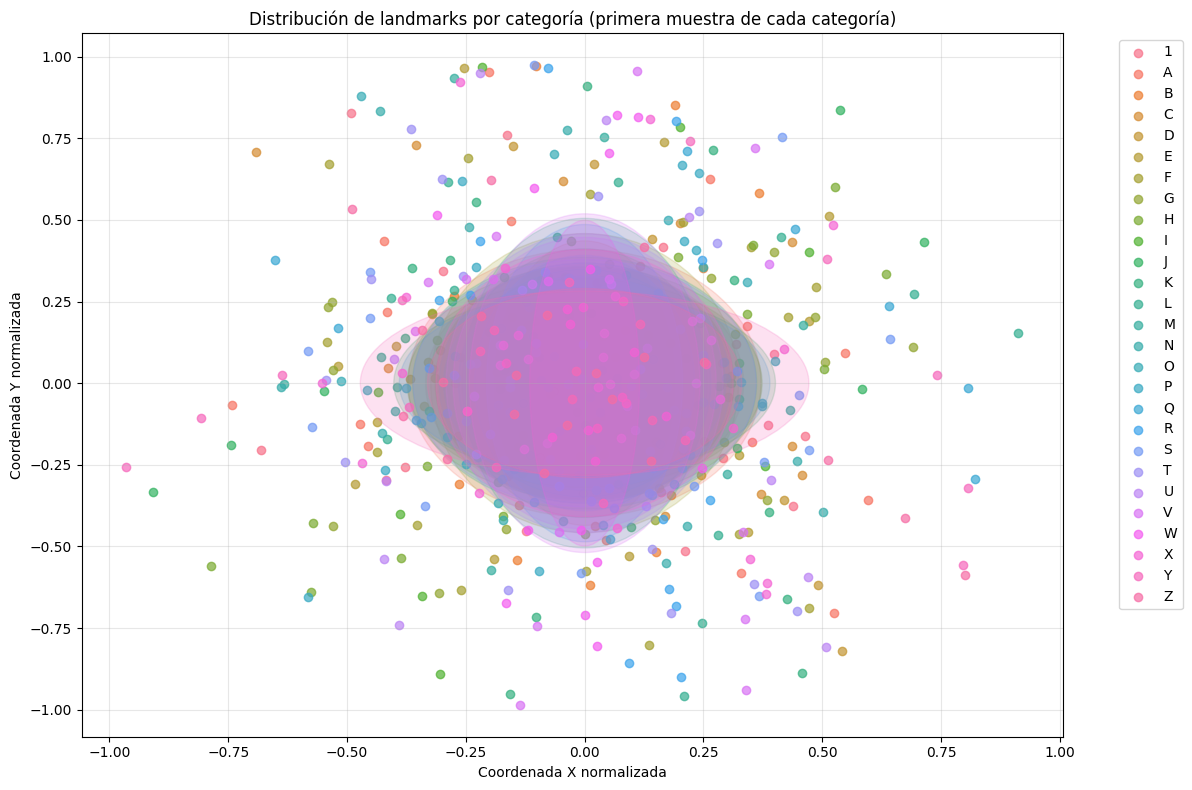

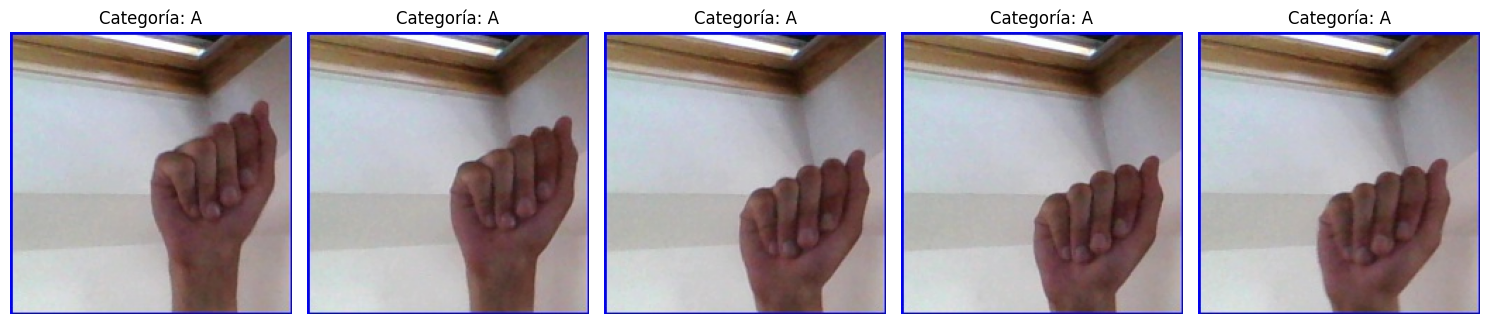

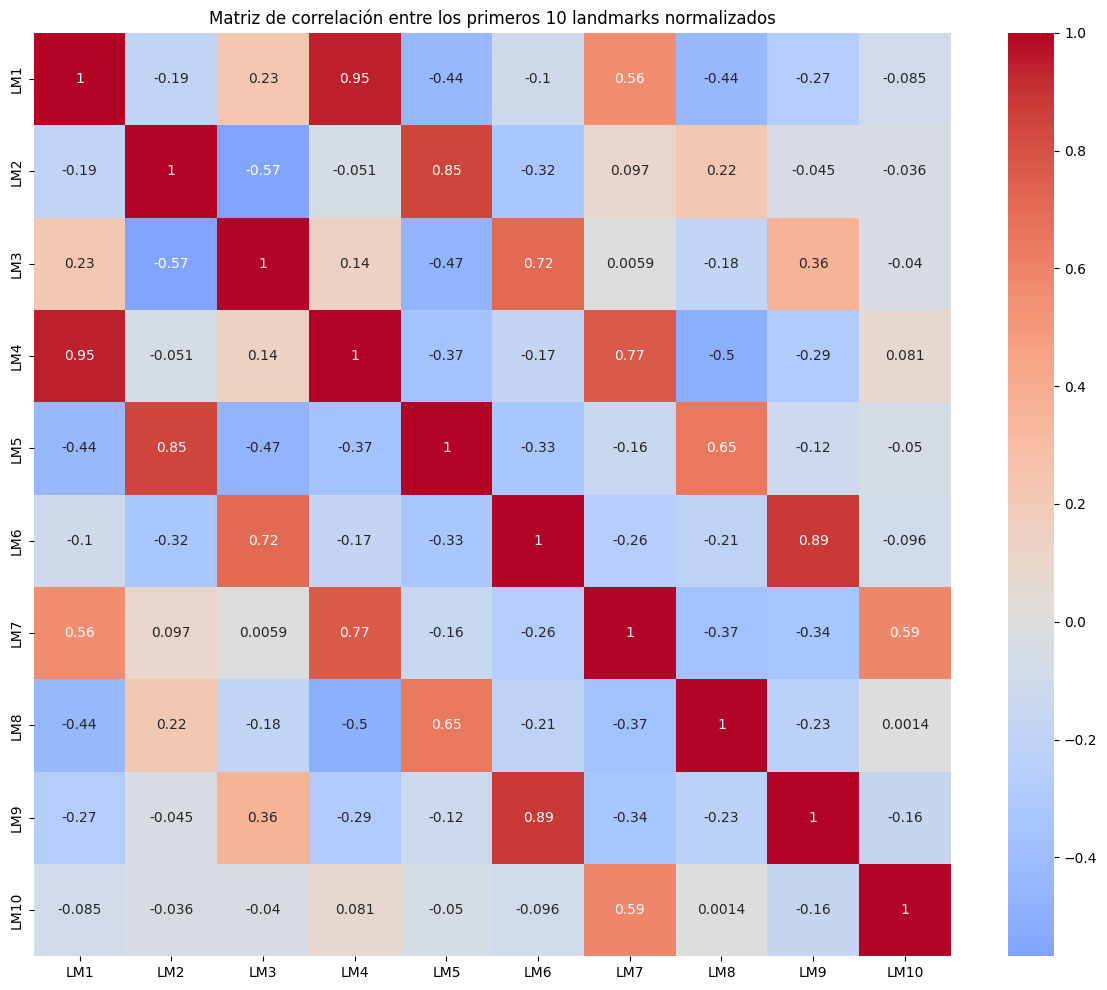

Procesadas 27 categorías: ['A', 'B', 'C', 'E', 'H', 'I', 'J', 'K', 'L', 'O', 'Q', 'R', 'S', 'V', 'W', 'X', 'Y', 'Z', '1', 'D', 'F', 'G', 'M', 'N', 'P', 'T', 'U']
Datos guardados: 58920 muestras con 63 características cada una
Visualizaciones guardadas en el directorio actual


In [2]:
import cv2
import mediapipe as mp
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5
)

base_path = "/home/sebastian/senials/entrenamiento/manos"

folders = {}
for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)
    if os.path.isdir(item_path):
        folders[item] = item_path

def extract_landmarks(image_path):
    imagen = cv2.imread(image_path)
    if imagen is None:
        return None
    imagen_rgb = cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB)
    result = hands.process(imagen_rgb)

    if result.multi_hand_landmarks:
        for hand_landmarks in result.multi_hand_landmarks:
            return np.array([[lm.x, lm.y, lm.z] for lm in hand_landmarks.landmark]).flatten()
    return None

def normalize_landmarks(X):
    X_norm = X.reshape(-1, 21, 3)
    centroides = np.mean(X_norm, axis=1, keepdims=True)
    X_centered = X_norm - centroides
    max_dists = np.max(np.linalg.norm(X_centered, axis=2), axis=1)
    X_scaled = X_centered / max_dists[:, None, None]
    return X_scaled.reshape(-1, 63)

# Extraer landmarks y etiquetas
data = []
labels = []
original_images = []  # Almacenar algunas imágenes para visualización

for label, folder_path in folders.items():
    # Corrección: Usar folder_path en lugar de fer_path
    for filename in os.listdir(folder_path):
        if filename.endswith(".jpg"):
            file_path = os.path.join(folder_path, filename)
            landmarks = extract_landmarks(file_path)
            if landmarks is not None:
                data.append(landmarks)
                labels.append(label)
                # Almacenar algunas imágenes para mostrar ejemplos
                if len(original_images) < 5 and np.random.random() < 0.1:
                    original_images.append((cv2.imread(file_path), label))

X = np.array(data)
y = np.array(labels)

# Normalizar landmarks
X_normalized = normalize_landmarks(X)

# Codificar etiquetas
unique_labels = np.unique(y)
y_encoded = np.array([np.where(unique_labels == label)[0][0] for label in y])

# =============================================================================
# VISUALIZACIONES
# =============================================================================

# 1. Distribución de clases
plt.figure(figsize=(10, 6))
sns.countplot(x=y)
plt.title('Distribución de muestras por categoría')
plt.xlabel('Categorías')
plt.ylabel('Número de muestras')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('distribucion_categorias.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. Visualización de landmarks originales vs normalizados
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Landmarks originales (primeras 2 dimensiones de los primeros 5 landmarks)
for i in range(min(5, X.shape[0])):
    landmarks_original = X[i].reshape(-1, 3)
    axes[0, 0].scatter(landmarks_original[:, 0], landmarks_original[:, 1], alpha=0.7)
    axes[0, 0].plot(landmarks_original[:, 0], landmarks_original[:, 1], '--', alpha=0.5)
axes[0, 0].set_title('Landmarks originales (primeras muestras)')
axes[0, 0].set_xlabel('Coordenada X')
axes[0, 0].set_ylabel('Coordenada Y')
axes[0, 0].invert_yaxis()  # Para coincidir con sistema de coordenadas de imagen

# Landmarks normalizados
for i in range(min(5, X_normalized.shape[0])):
    landmarks_norm = X_normalized[i].reshape(-1, 3)
    axes[0, 1].scatter(landmarks_norm[:, 0], landmarks_norm[:, 1], alpha=0.7)
    axes[0, 1].plot(landmarks_norm[:, 0], landmarks_norm[:, 1], '--', alpha=0.5)
axes[0, 1].set_title('Landmarks normalizados (primeras muestras)')
axes[0, 1].set_xlabel('Coordenada X normalizada')
axes[0, 1].set_ylabel('Coordenada Y normalizada')

# 3. Distribución de valores de landmarks
sns.violinplot(data=X[:, :3], ax=axes[1, 0])  # Primeros 3 valores (primer landmark)
axes[1, 0].set_title('Distribución de valores de landmarks originales (primer landmark)')
axes[1, 0].set_ylabel('Valor')
axes[1, 0].set_xticklabels(['X', 'Y', 'Z'])

sns.violinplot(data=X_normalized[:, :3], ax=axes[1, 1])  # Primeros 3 valores normalizados
axes[1, 1].set_title('Distribución de valores de landmarks normalizados (primer landmark)')
axes[1, 1].set_ylabel('Valor normalizado')
axes[1, 1].set_xticklabels(['X', 'Y', 'Z'])

plt.tight_layout()
plt.savefig('comparacion_landmarks.png', dpi=300, bbox_inches='tight')
plt.show()

# 4. Proyección 2D de todos los landmarks (usando PCA conceptual)
# Dado que no podemos usar sklearn, hacemos una proyección simple promediando landmarks
mean_landmarks_by_category = []
categories = []

for label in unique_labels:
    indices = np.where(y == label)[0]
    if len(indices) > 0:
        mean_landmarks = np.mean(X_normalized[indices].reshape(-1, 63), axis=0)
        mean_landmarks_by_category.append(mean_landmarks)
        categories.append(label)

mean_landmarks_by_category = np.array(mean_landmarks_by_category)

# Visualización de promedios por categoría
plt.figure(figsize=(12, 8))
colors = sns.color_palette("husl", len(unique_labels))

for i, category in enumerate(unique_labels):
    # Tomar el promedio de los landmarks para esta categoría
    indices = np.where(y == category)[0]
    if len(indices) > 0:
        sample_landmarks = X_normalized[indices[0]].reshape(-1, 3)
        plt.scatter(sample_landmarks[:, 0], sample_landmarks[:, 1], 
                   color=colors[i], alpha=0.7, label=category)
        
        # Dibujar una elipse alrededor de los puntos para representar variabilidad
        if len(indices) > 1:
            ell = Ellipse(xy=(np.mean(sample_landmarks[:, 0]), np.mean(sample_landmarks[:, 1])),
                         width=np.std(sample_landmarks[:, 0])*2, 
                         height=np.std(sample_landmarks[:, 1])*2,
                         angle=0, color=colors[i], alpha=0.2)
            plt.gca().add_patch(ell)

plt.title('Distribución de landmarks por categoría (primera muestra de cada categoría)')
plt.xlabel('Coordenada X normalizada')
plt.ylabel('Coordenada Y normalizada')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('landmarks_por_categoria.png', dpi=300, bbox_inches='tight')
plt.show()

# 5. Ejemplos de imágenes originales con landmarks
if original_images:
    fig, axes = plt.subplots(1, len(original_images), figsize=(15, 5))
    if len(original_images) == 1:
        axes = [axes]
    
    for idx, (img, label) in enumerate(original_images):
        axes[idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        axes[idx].set_title(f'Categoría: {label}')
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('ejemplos_imagenes.png', dpi=300, bbox_inches='tight')
    plt.show()

# 6. Matriz de correlación de landmarks (primeros 10)
plt.figure(figsize=(12, 10))
corr_matrix = np.corrcoef(X_normalized[:, :10].T)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            xticklabels=[f'LM{i}' for i in range(1, 11)],
            yticklabels=[f'LM{i}' for i in range(1, 11)])
plt.title('Matriz de correlación entre los primeros 10 landmarks normalizados')
plt.tight_layout()
plt.savefig('correlacion_landmarks.png', dpi=300, bbox_inches='tight')
plt.show()

# Guardar datos preprocesados
np.savez('preprocessed_data.npz', X=X_normalized, y=y_encoded, labels=unique_labels)

print(f"Procesadas {len(folders)} categorías: {list(folders.keys())}")
print(f"Datos guardados: {X_normalized.shape[0]} muestras con {X_normalized.shape[1]} características cada una")
print("Visualizaciones guardadas en el directorio actual")

Epoch 1/50


/home/sebastian/senials/estable/lib/python3.12/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-08-31 20:39:02.621660: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


1473/1473 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6915 - loss: 1.1363 - val_accuracy: 0.9871 - val_loss: 0.0585
Epoch 2/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9768 - loss: 0.1077 - val_accuracy: 0.9902 - val_loss: 0.0431
Epoch 3/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9856 - loss: 0.0693 - val_accuracy: 0.9916 - val_loss: 0.0370
Epoch 4/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9859 - loss: 0.0627 - val_accuracy: 0.9922 - val_loss: 0.0348
Epoch 5/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9888 - loss: 0.0475 - val_accuracy: 0.9931 - val_loss: 0.0295
Epoch 6/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.9888 - loss: 0.0441 - val_accuracy: 0.9942 - val_loss: 0.0261
Epoch 7/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.9905 - loss: 0.0411 - val_accuracy: 0.9938 - val_loss: 0.0266
Epoch 8/50
1473/1473 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9902 - loss: 0.0374 - val_accurac

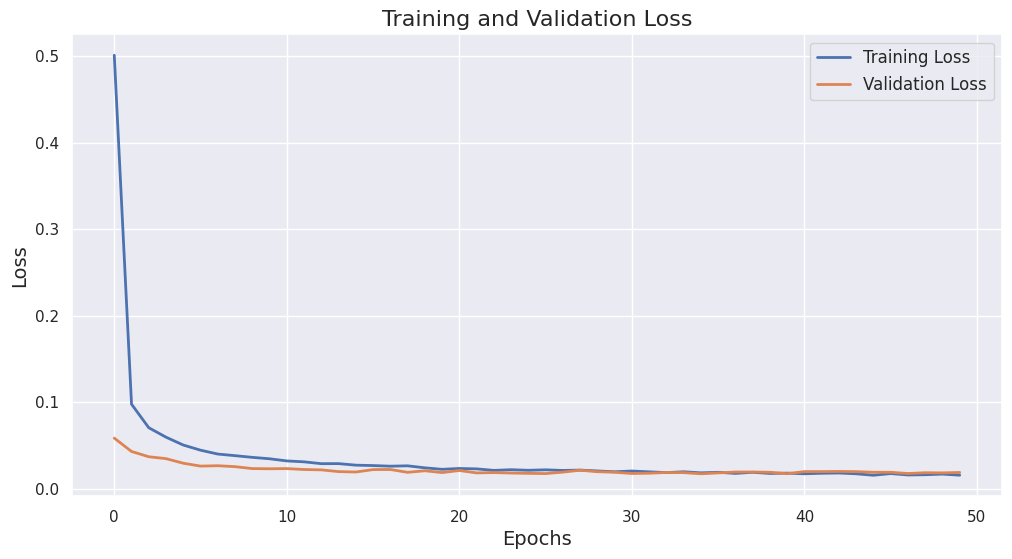

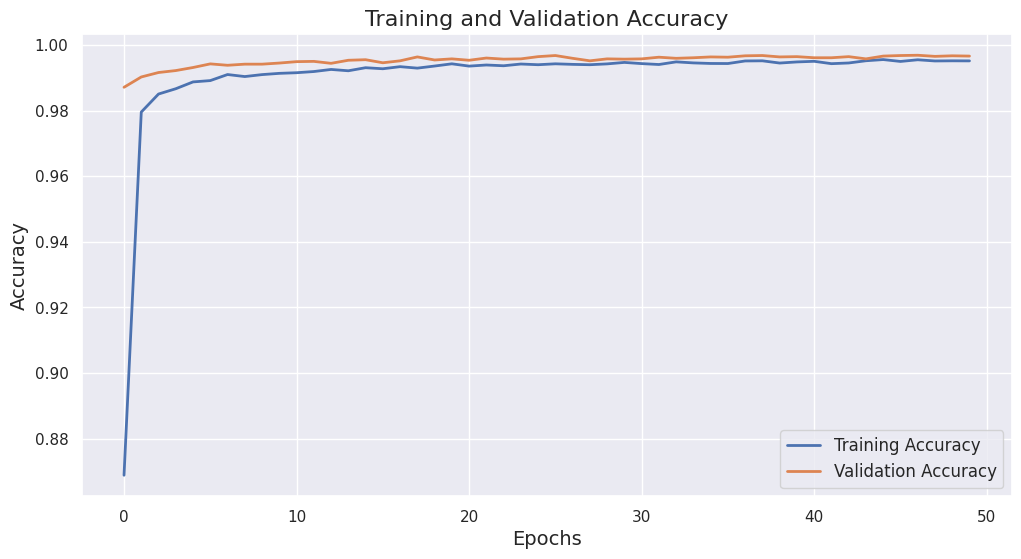

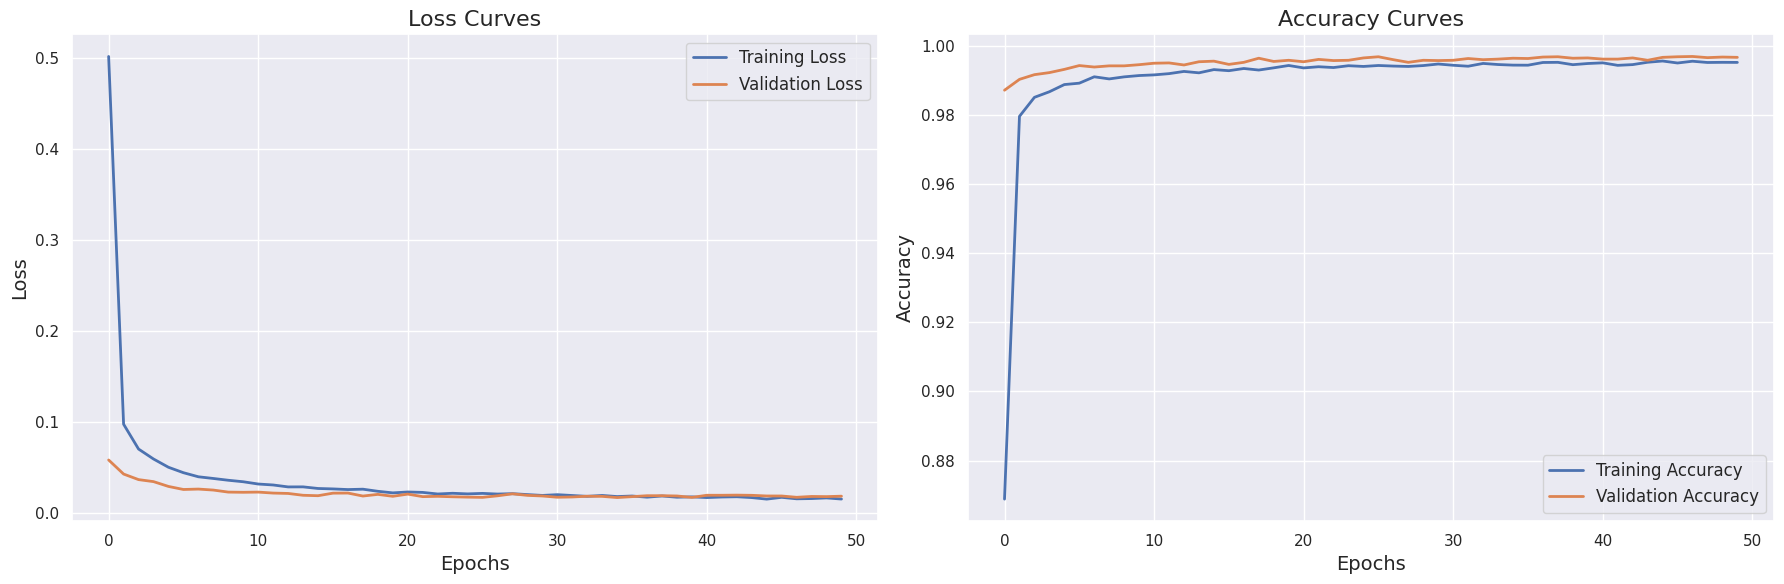

369/369 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


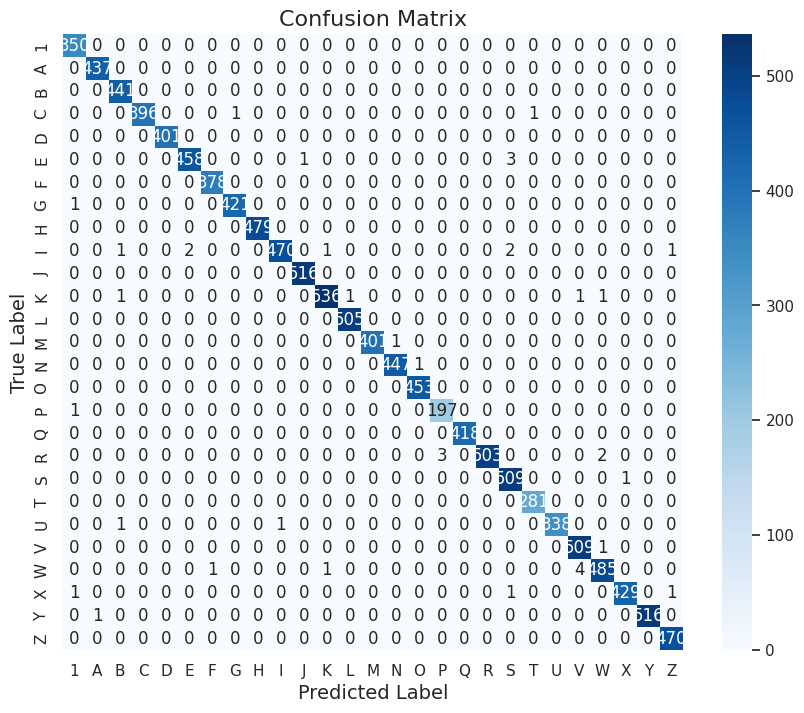

NameError: name 'learning_curve' is not defined

In [3]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd

# Configurar el estilo de los gráficos
sns.set_theme(style="darkgrid")
plt.rcParams['figure.figsize'] = (12, 8)

# Cargar datos preprocesados
data = np.load('preprocessed_data.npz')
X_normalized = data['X']
y_encoded = data['y']
unique_labels = data['labels']

# Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X_normalized, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Definir y compilar el modelo
model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(63,)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(len(unique_labels), activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entrenar el modelo y almacenar el historial
history = model.fit(
    X_train, y_train, 
    epochs=50, 
    validation_data=(X_test, y_test), 
    verbose=1
)

# Guardar modelo entrenado
model.save('model.keras')

# 1. Gráfico de Pérdida (Loss) durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 2. Gráfico de Precisión (Accuracy) durante el entrenamiento
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.show()

# 3. Gráfico combinado de Pérdida y Precisión
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
ax[0].plot(history.history['loss'], label='Training Loss', linewidth=2)
ax[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
ax[0].set_title('Loss Curves', fontsize=16)
ax[0].set_xlabel('Epochs', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(fontsize=12)

ax[1].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
ax[1].set_title('Accuracy Curves', fontsize=16)
ax[1].set_xlabel('Epochs', fontsize=14)
ax[1].set_ylabel('Accuracy', fontsize=14)
ax[1].legend(fontsize=12)
plt.tight_layout()
plt.show()

# 4. Matriz de Confusión
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=unique_labels, 
            yticklabels=unique_labels)
plt.title('Confusion Matrix', fontsize=16)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.show()

# 5. Curvas de Aprendizaje (Learning Curves)
train_sizes = np.linspace(0.1, 1.0, 5)
train_sizes, train_scores, test_scores = learning_curve(
    model, X_normalized, y_encoded, train_sizes=train_sizes, cv=5, scoring='accuracy'
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 6))
plt.plot(train_sizes, train_mean, label='Training Accuracy', color='blue', marker='o')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, label='Validation Accuracy', color='green', marker='s')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.title('Learning Curves', fontsize=16)
plt.xlabel('Training Set Size', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# 6. Gráfico de Distribución de Pérdidas
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 6))
sns.histplot(train_loss, label='Training Loss', kde=True, color='blue', element='step')
sns.histplot(val_loss, label='Validation Loss', kde=True, color='red', element='step')
plt.title('Distribution of Losses', fontsize=16)
plt.xlabel('Loss Value', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(fontsize=12)
plt.show()